In [ ]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats

In [30]:
import os
os.chdir('/content/drive/MyDrive/Tensorflow Advance/Practice/CatDog')

import tensorflow as tf
from shutil import move
import zipfile
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image
import imageio
import random

In [7]:
f = zipfile.ZipFile('./train.zip','r')
f.extractall()

In [8]:
os.mkdir("data")
os.mkdir("./data/train")
os.mkdir("./data/train/dog")
os.mkdir("./data/train/cat")

In [9]:
os.mkdir("./data/test")
os.mkdir("./data/test/dog")
os.mkdir("./data/test/cat")

In [10]:
data_dir = "./train/"

train_des_dir_dog = "./data/train/dog/"
train_des_dir_cat = "./data/train/cat/"

test_des_dir_dog = "./data/test/dog/"
test_des_dir_cat = "./data/test/cat/"

In [11]:
len(os.listdir(data_dir))

25000

In [12]:
for fl in os.listdir(data_dir):
    if 'cat' in fl:
        a = move(data_dir+fl , train_des_dir_dog)
    elif 'dog' in fl:
        a = move(data_dir+fl , train_des_dir_cat)

In [13]:
print("Tota no of cat images : ",len(os.listdir(train_des_dir_dog)))
print("Tota no of dog images : ",len(os.listdir(train_des_dir_cat)))

Tota no of cat images :  12500
Tota no of dog images :  12500


In [14]:
for fl in os.listdir(train_des_dir_dog)[-2500:]:
    a = move(train_des_dir_dog+fl , test_des_dir_dog)

In [15]:
for fl in os.listdir(train_des_dir_cat)[-2500:]:
    a = move(train_des_dir_cat+fl , test_des_dir_cat)

In [16]:
train_dir = "./data/train/"
test_dir  = "./data/test/"

In [17]:
def print_dir_details(d):
    for dir in os.listdir(d): 
        print("No of %s is : %d"%(dir , len(os.listdir(d+dir))))

In [18]:
print("TRAIN DATA DETAILS :\n====================================")
print_dir_details(train_dir)

print("TEST  DATA DETAILS :\n====================================")
print_dir_details(test_dir)

TRAIN DATA DETAILS :
No of dog is : 10000
No of cat is : 10000
TEST  DATA DETAILS :
No of dog is : 2500
No of cat is : 2500


In [19]:
shutil.rmtree(data_dir)

In [20]:
train_data_gen  =  tf.keras.preprocessing.image.ImageDataGenerator(rescale=(1.0 / 255.0))
test_data_gen   =  tf.keras.preprocessing.image.ImageDataGenerator(rescale=(1.0 / 255.0))

In [21]:
train_data = train_data_gen.flow_from_directory(train_dir ,
                                                target_size=(150,150),
                                                class_mode='binary' ,
                                                batch_size=64)

test_data = test_data_gen.flow_from_directory(test_dir ,
                                              target_size=(150,150),
                                              class_mode='binary' ,
                                              batch_size=64)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [22]:
print("Image shape : ",train_data[0][0][0].shape)
print("label shape : ",train_data[0][1][0].shape)

Image shape :  (150, 150, 3)
label shape :  ()


In [43]:
def get_basic_toy_cnn_model():
    #toy modle
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128,(3,3),activation=tf.nn.relu , input_shape=(150,150,3)),
        tf.keras.layers.MaxPool2D((2,2)),

        tf.keras.layers.Conv2D(64,(3,3),activation=tf.nn.relu ),
        tf.keras.layers.MaxPool2D((2,2)),

        tf.keras.layers.Conv2D(32,(3,3),activation=tf.nn.relu ),
        tf.keras.layers.MaxPool2D((2,2)),
        
        tf.keras.layers.Conv2D(32,(3,3),activation=tf.nn.relu ),
        tf.keras.layers.MaxPool2D((2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128,activation=tf.nn.relu),
        tf.keras.layers.Dense(128,activation=tf.nn.relu),
        tf.keras.layers.Dense(1 , activation=tf.nn.sigmoid)
    ])
    model.compile(optimizer=tf.keras.optimizers.RMSprop() ,
                loss = tf.keras.losses.binary_crossentropy ,
                metrics = ['acc'])
    return model

In [97]:
plt.rc('figure' , figsize = (20,4))
plt.rc('font'   , size = 20)

def display_image(image , output , y_true):
    mod_output = []
    plt.xticks([])
    plt.yticks([])
    plt.grid(None)
    for i in output:
        if i==1:
            mod_output.append('CAT')
        else:
            mod_output.append('DOG')
    a = np.swapaxes(image, 0 , 1).reshape((150,900,3))
    plt.imshow(a)
    plt.xticks([150 * x + 75 for x in range(6)] , mod_output)

    for i in range(len(plt.gca().xaxis.get_ticklabels())):
        if y_true[i] == output[i]:
            plt.gca().xaxis.get_ticklabels()[i].set_color('green')
        else:
            plt.gca().xaxis.get_ticklabels()[i].set_color('red')

    plt.grid(None)

In [100]:
class MyOwnCallBacks(tf.keras.callbacks.Callback):
    def __init__(self , data , label):
        self.data = data
        self.label = label
        self.images = []

    def on_epoch_end(self,epoch,logs={}):
        rand_6_num = np.random.choice(np.arange(64) , size=6)
        display_image(self.data[rand_6_num] , self.model.predict_classes(self.data[rand_6_num]).reshape((6,)) , self.label[rand_6_num])
        name = "img.png"
        plt.savefig(name)
        image = Image.open(name)
        self.images.append(np.array(image))

        if epoch % 4 == 0:
            plt.show()
    
    def on_train_end(self , logs = {}):
        imageio.mimsave('./animation.gif' , self.images , fps = 1)

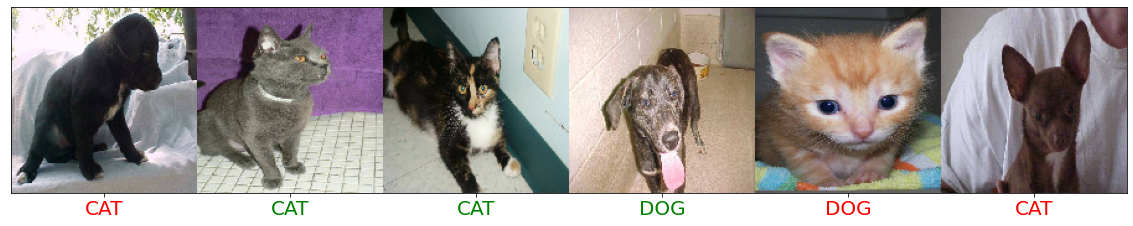

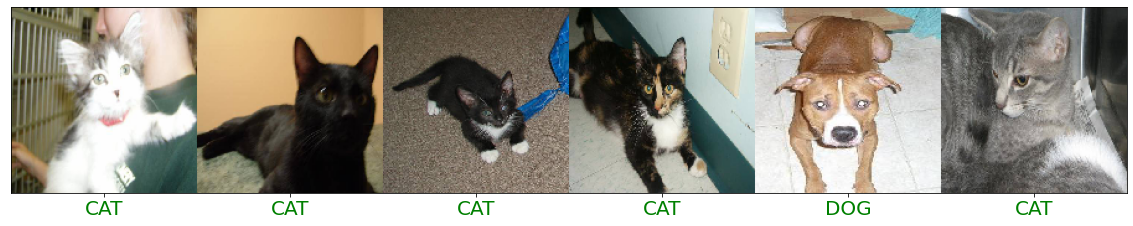

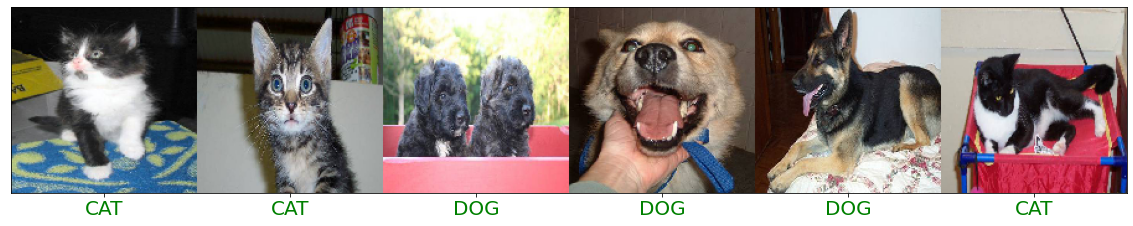

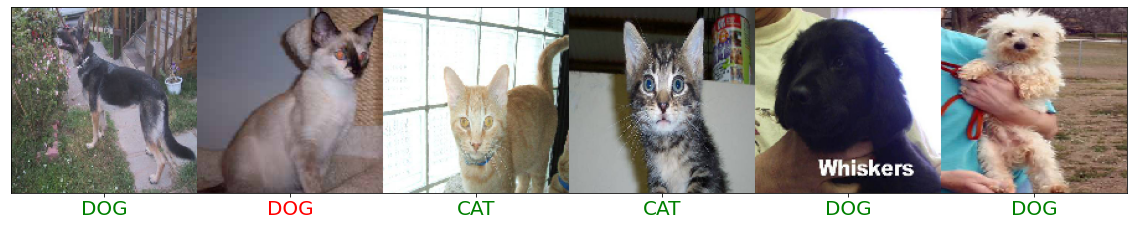

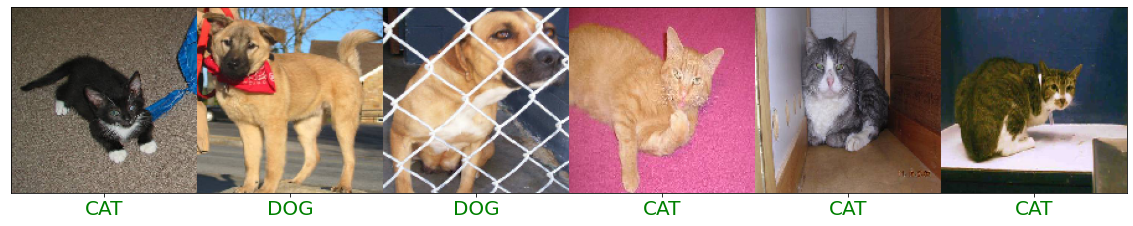

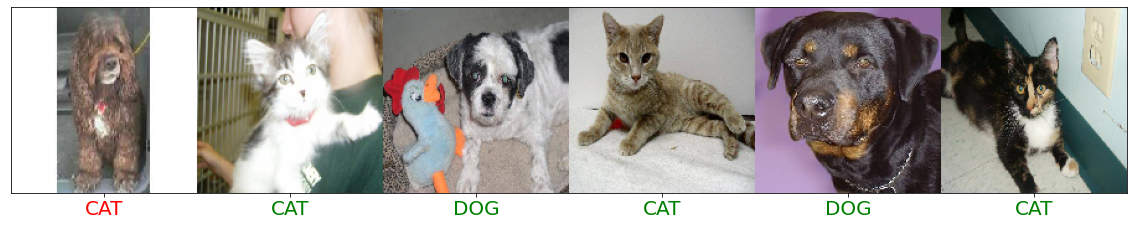

In [101]:
model = get_basic_toy_cnn_model()
rand_ind = random.randint(0 , test_data.n // test_data.batch_size)
cb = MyOwnCallBacks(test_data[0][0] , test_data[0][1])
model.fit(train_data ,
          steps_per_epoch=train_data.n // train_data.batch_size ,
          epochs=20 ,
          validation_data=test_data ,
          validation_steps=test_data.n // test_data.batch_size,
          callbacks = [cb],
          verbose = 0
          )

In [102]:
model.evaluate(train_data)

313/313 [==============================] - 80s 255ms/step - loss: 0.0209 - acc: 0.9924


[0.020871100947260857, 0.9924499988555908]

In [103]:
model.evaluate(test_data)

79/79 [==============================] - 19s 244ms/step - loss: 0.8050 - acc: 0.8680


[0.8049972057342529, 0.8679999709129333]